# Train your custom YOLOv5 Visual Inspection model
*Based on and inspired by the  [Yolov5 Tutorials](https://github.com/ultralytics/yolov5/wiki/) by  [Ultralytics](https://ultralytics.com)*

In this notebook we are going to train a custom Yolov5 model for detecting anomalies in images. The data set for this demonstrator is based on the Metal Nut Data Set from mvtec.com

**Metal Nut Data Set**
- Credits to https://www.mvtec.com/company/research/datasets
- See also: https://www.mvtec.com/company/research/datasets/mvtec-ad

**ATTRIBUTION**

Paul Bergmann, Michael Fauser, David Sattlegger, Carsten Steger. MVTec AD - A Comprehensive Real-World Dataset for Unsupervised Anomaly Detection; in: IEEE Conference on Computer Vision and Pattern Recognition (CVPR), June 2019

**LICENSE**

The data is released under the Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License (CC BY-NC-SA 4.0). For using the data in a way that falls under the commercial use clause of the license, please contact us via the form below.

# Setup

Clone GitHub [repository](https://github.com/ultralytics/yolov5), install [dependencies](https://github.com/ultralytics/yolov5/blob/master/requirements.txt) and check PyTorch and GPU.

In [1]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install

Cloning into 'yolov5'...
remote: Enumerating objects: 15656, done.
remote: Counting objects: 100% (263/263), done.
remote: Compressing objects: 100% (161/161), done.
remote: Total 15656 (delta 137), reused 179 (delta 102), pack-reused 15393
Receiving objects: 100% (15656/15656), 14.66 MiB | 13.13 MiB/s, done.
Resolving deltas: 100% (10661/10661), done.
/opt/app-root/src/manuela-visual-inspection/ml/pytorch/yolov5

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Install opencv-python-headless many to avoid `ImportError: libGL.so.1: cannot open shared object file: No such file or directory`

In [2]:
!pip install opencv-python-headless

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 MB 245.4 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [3]:
import torch
import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v7.0-165-ge382d4c Python-3.9.14 torch-2.0.1+cu117 CUDA:0 (Tesla T4, 14928MiB)


Setup complete ✅ (8 CPUs, 30.9 GB RAM, 40.7/99.5 GB disk)


# Test the setup 

`detect.py` runs YOLOv5 inference on a variety of sources, downloading models automatically from the [latest YOLOv5 release](https://github.com/ultralytics/yolov5/releases), and saving results to `runs/detect`. Example inference sources are:

```shell
python detect.py --source 0  # webcam
                          img.jpg  # image 
                          vid.mp4  # video
                          screen  # screenshot
                          path/  # directory
                         'path/*.jpg'  # glob
                         'https://youtu.be/Zgi9g1ksQHc'  # YouTube
                         'rtsp://example.com/media.mp4'  # RTSP, RTMP, HTTP stream
```

detect: weights=['yolov5s.pt'], source=data/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-165-ge382d4c Python-3.9.14 torch-2.0.1+cu117 CUDA:0 (Tesla T4, 14928MiB)

100%|███████████████████████████████████████| 14.1M/14.1M [00:00<00:00, 310MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
image 1/2 /opt/app-root/src/manuela-visual-inspection/ml/pytorch/yolov5/data/images/bus.jpg: 640x480 4 persons, 1 bus, 41.3ms
image 2/2 /opt/app-root/src/manuela-visual-inspection/ml/pytorch/yolov5/data/images/zidane.jpg: 384x640 2 persons, 2 ties, 40.9ms
Speed: 0.6ms pre-process, 41.1ms inference, 1.5m

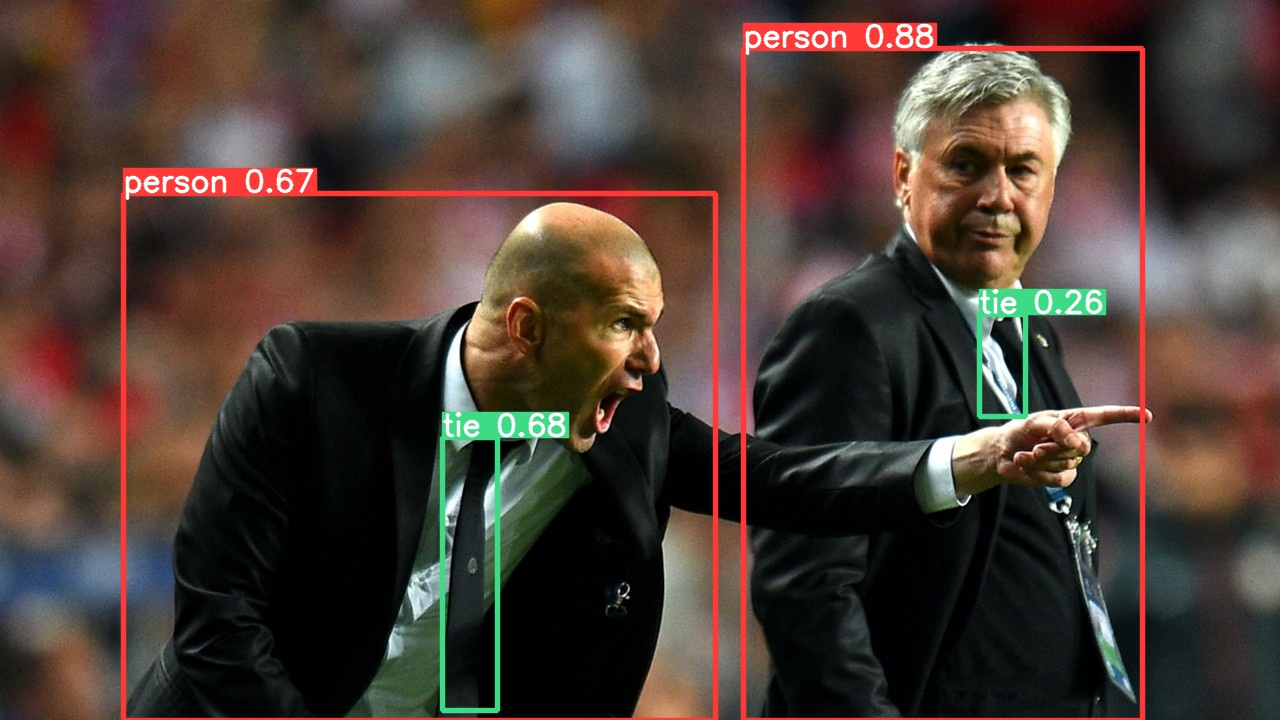

In [4]:
!python detect.py --weights yolov5s.pt --img 640 --conf 0.25 --source data/images
display.Image(filename='runs/detect/exp/zidane.jpg', width=600)

# What are YOLO v5 Annotations?
Before starting the model training, let's have a brief look at the required annotations.


## YOLO v5 Annotation Format
YOLO v5 expects annotations for each image in form of a .txt file where each line of the text file describes a bounding box. Consider the following image:

![zidane](../../images/zidane.jpg)

The annotation file for the image above looks like the following:

![zidane-txt](../../images/zidane-txt.png)

There are 3 objects in total (2 persons and one tie). Each line represents one of these objects. The specification for each line is as follows:

- One row per object
- Each row is class x_center y_center width height format.
- Box coordinates must be normalized by the dimensions of the image (i.e. have values between 0 and 1)
- Class numbers are zero-indexed (start from 0).

Source: [train-yolov5-custom-data](https://blog.paperspace.com/train-yolov5-custom-data/#convert-the-annotations-into-the-yolo-v5-format)

# Data preparation
Data preparation is usually a big task. You might have to clean the data. Label the data - in computer vision it means creating the bounding boxes. And also split the data into training and test data sets.

We are lucky, because this (hard) work has been done already. You just need to Unzip the images and annotations. 

**Unzip the images and annotations:**

In [5]:
# Unzip the images and annoations
!mkdir -p data/manuela
!unzip  -q -o  ../data.zip -d data/manuela
!ls -l data/manuela/data/*

total 20
-rw-r--r--. 1 1000900000 1000900000  137 Apr 21 09:54 data.yaml
-rw-r--r--. 1 1000900000 1000900000  659 Apr  7 12:17 README.txt
drwxr-sr-x. 4 1000900000 1000900000 4096 Apr  7 12:13 test
drwxr-sr-x. 4 1000900000 1000900000 4096 Apr  7 12:13 train
drwxr-sr-x. 4 1000900000 1000900000 4096 Apr  7 12:13 valid


**View example image:** 

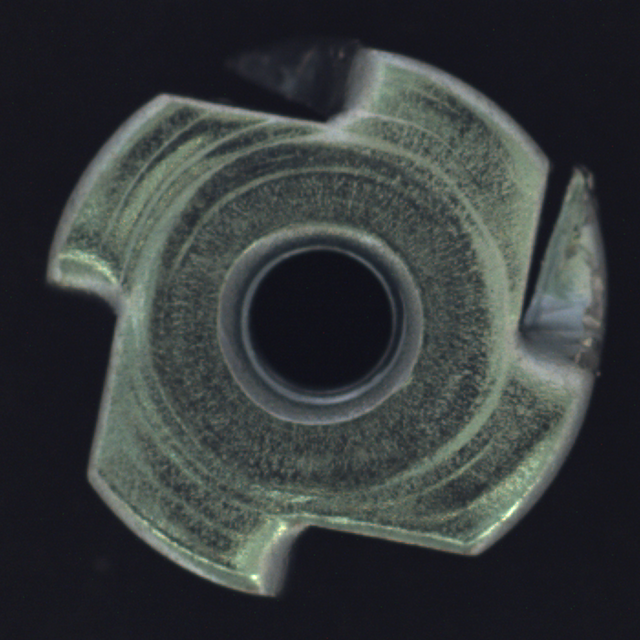

In [6]:
# View image 
display.Image(filename='data/manuela/data/metal-nut-data/valid/images/bent-000.png', width=600)

**Explore the Yolo annotation for the image:**

Let's have look at the annotation file for the image. It contains two "bent".

In [7]:
# Show annotation
!cat data/manuela/data/metal-nut-data/valid/labels/bent-000.txt

1 0.8842857142857142 0.425 0.13714285714285715 0.33285714285714285
1 0.46 0.11857142857142858 0.22 0.13142857142857142


Two "objects" are listed in the `bent-000.txt` and they map to the two bounding boxes:

![bent-000-bb](../../images/bent-000-bb.png)

# Start model training 
Train a YOLOv5m model on the metal-nut data by specifying dataset, batch-size, image size and pretrained --weights yolov5m.pt. Pretrained weights are auto-downloaded from the latest [YOLOv5 release](https://github.com/ultralytics/yolov5/releases).

Before starting, check this:
- `--workers 0` is a workaround for problem with shared memory limit
- Or, extend the share memory for your notebook as describe in the local [README.md](README.md) and remove `--workers 0` below.

In [8]:
!python train.py --img 640 --batch 16 --epochs 600 --data data/metal-nut-data/data.yaml --weights yolov5m.pt 

train: weights=yolov5m.pt, cfg=, data=data/metal-nut-data/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=600, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-165-ge382d4c Python-3.9.14 torch-2.0.1+cu117 CUDA:0 (Tesla T4, 14928MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_

# Test model
Depending on how many runs you already tried, please update `exp7`. See `saved to runs/train/exp` above.

In [9]:
!python detect.py --weights runs/train/exp/weights/best.pt --img 640 --conf 0.25 --source data/manuela/data/metal-nut-data/valid/images/bent-000.png


detect: weights=['runs/train/exp/weights/best.pt'], source=data/manuela/data/metal-nut-data/valid/images/bent-000.png, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-165-ge382d4c Python-3.9.14 torch-2.0.1+cu117 CUDA:0 (Tesla T4, 14928MiB)

Fusing layers... 
Model summary: 212 layers, 20856975 parameters, 0 gradients, 47.9 GFLOPs
image 1/1 /opt/app-root/src/manuela-visual-inspection/ml/pytorch/yolov5/data/manuela/data/metal-nut-data/valid/images/bent-000.png: 640x640 2 bents, 19.5ms
Speed: 0.6ms pre-process, 19.5ms inference, 2.1ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp2


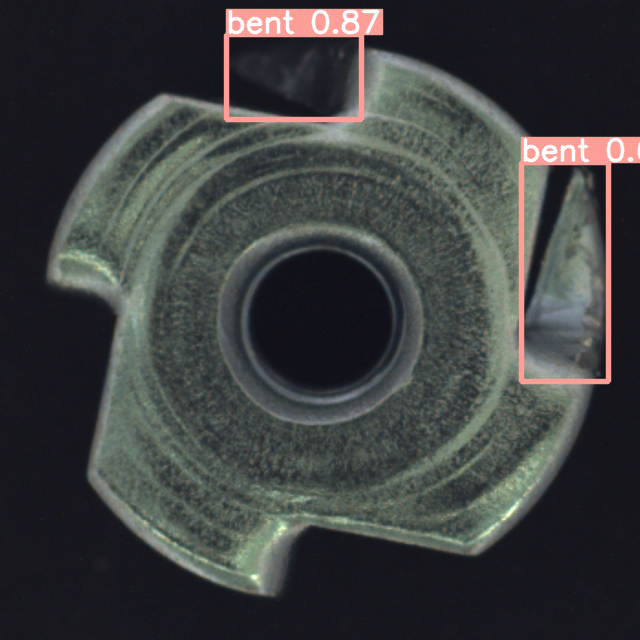

In [10]:
display.Image(filename='runs/detect/exp2/bent-000.png', width=600)

# Export YoloV5 model to ONNX format
Source: [01-yolov5_to_onnx.ipynb](https://github.com/rh-aiservices-bu/yolov5-model-serving/blob/main/01-yolov5_to_onnx.ipynb)
* Eventually modify the image size if you selected  a model with the "6" suffix, as image size is 1280 (and not 640)
* Stay at opset 16 for the moment for OpenVino model server compatibility

Please change `exp7` with your latest run number.

In [11]:
!python export.py --weights runs/train/exp/weights/best.pt --include onnx --imgsz 640 --opset 16

export: data=data/coco128.yaml, weights=['runs/train/exp/weights/best.pt'], imgsz=[640], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=16, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['onnx']
YOLOv5 🚀 v7.0-165-ge382d4c Python-3.9.14 torch-2.0.1+cu117 CPU

Fusing layers... 
Model summary: 212 layers, 20856975 parameters, 0 gradients, 47.9 GFLOPs

PyTorch: starting from runs/train/exp/weights/best.pt with output shape (1, 25200, 7) (40.3 MB)

ONNX: starting export with onnx 1.14.0...
============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

ONNX: export success ✅ 2.5s, saved as runs/train/exp/weights/best.onnx (80.0 MB)

Export complete (4.1s)
Results saved to /opt/app-root/

# Upload onnx model to your S3 bucket for model serving

In [13]:
# Check if and where onnx file exixts
!ls -l runs/train/exp/weights/best.onnx

-rw-r--r--. 1 1000900000 1000900000 83890314 May 12 14:22 runs/train/exp/weights/best.onnx


In [14]:
# Install boto3
!pip install boto3


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [16]:
from upload_model import upload_model
import boto3

upload_model("runs/train/exp/weights/best.onnx", "manu-vi-best.onnx")

src_file: "runs/train/exp/weights/best.onnx"
target_object_name: "manu-vi-best.onnx"
initializing S3 client
uploading model to bucket manu-vi-stb as manu-vi-best.onnx
model uploaded and available as "manu-vi-best.onnx"


# Optionally, save work into tar file for download

In [28]:
!tar -czvf manu-vi-yolo5-run.tar.gz runs/

runs/
runs/detect/
runs/detect/exp2/
runs/detect/exp2/bent-002.png
runs/detect/exp/
runs/detect/exp/bent-001.png
runs/detect/exp5/
runs/detect/exp5/scratch-001.png
runs/detect/exp4/
runs/detect/exp4/scratch-000.png
runs/detect/exp3/
runs/detect/exp6/
runs/detect/exp6/bent-000.png
runs/train/
runs/train/exp/
runs/train/exp/train_batch2.jpg
runs/train/exp/train_batch0.jpg
runs/train/exp/labels.jpg
runs/train/exp/train_batch1.jpg
runs/train/exp/R_curve.png
runs/train/exp/PR_curve.png
runs/train/exp/F1_curve.png
runs/train/exp/results.csv
runs/train/exp/val_batch0_labels.jpg
runs/train/exp/P_curve.png
runs/train/exp/confusion_matrix.png
runs/train/exp/opt.yaml
runs/train/exp/hyp.yaml
runs/train/exp/labels_correlogram.jpg
runs/train/exp/events.out.tfevents.1680957814.8519c2bd1d4d.1194.0
runs/train/exp/results.png
runs/train/exp/weights/
runs/train/exp/weights/last.pt
runs/train/exp/weights/best.onnx
runs/train/exp/weights/best.pt
runs/train/exp/val_batch0_pred.jpg
